In [3]:
# Install gpflow dependency 
!pip install gpflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 383 kB 8.6 MB/s 
     |████████████████████████████████| 104 kB 49.1 MB/s 


In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import gpflow

import matplotlib
matplotlib.rcParams['figure.figsize'] = (14, 6)

# Classification with sparse GPs

### James Hensman 2017 - 2022

This notebook serves as a tutorial: the aim is to understand how GP classification with sparse approximations work in GPflow.

First, let's have a look at the illustrative dataset from the lecture. Here's how it was generated:

(-1.5, 2.5)

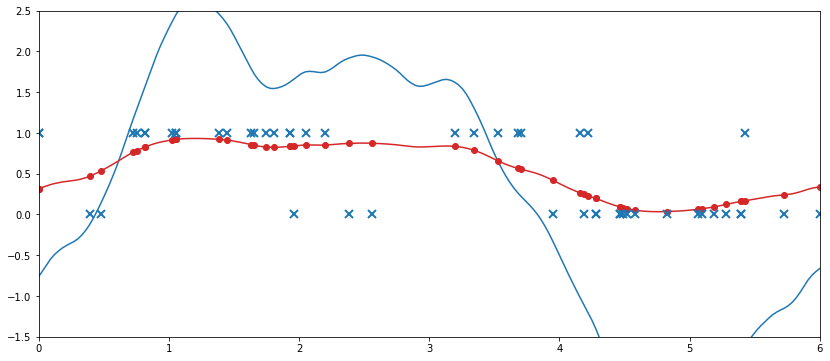

In [6]:
# Draw a sample from a GP

# first build the kernel and kernel matrix
k = gpflow.kernels.Matern52(variance=6.0)
X_all = np.linspace(0, 6, 200).reshape(-1, 1)
K = k(X_all)

# sample from a multivariate normal
L = np.linalg.cholesky(K)
f_all = np.dot(L, np.random.RandomState(6).randn(200, 1))
plt.plot(X_all, f_all, 'C0')

# squash
p_all = np.exp(f_all) / (1 + np.exp(f_all))
plt.plot(X_all, p_all, 'C3')

# evaluate a small number of points
ind = np.random.randint(0, 200, (50,))
X = X_all[ind]
p = p_all[ind]
plt.plot(X, p, 'C3o', ms=6)


# bernoulli draws
Y = np.where(np.random.rand(50, 1) < p, 1, 0)
plt.plot(X, Y, 'C0x', ms=8, mew=2)

plt.xlim(0, 6)
plt.ylim(-1.5, 2.5)

### Exercise 1: the effect of the parameters on classification datasets

a) Change the variance parameter in the kernel above (try 100, 0.01). What is the effect on the data X, Y ?

b) What is the effect of the lengthscale parameter on X and Y?

Now let's build a GPflow model of these data.

In [12]:
# here's a GPflow model. it assumes that the inducing locations Z are fixed to the data X.
# We'll tell the model that the data are Binary (Bernoulli likelihood), and we'll pick a kernel.
m = gpflow.models.SVGP(likelihood=gpflow.likelihoods.Bernoulli(),
                       kernel=gpflow.kernels.Matern52(),
                       inducing_variable=X.copy())
gpflow.set_trainable(m.inducing_variable, False)

o = gpflow.optimizers.Scipy()
o.minimize(m.training_loss_closure((X, Y)), m.trainable_variables)

      fun: 25.542094326736258
 hess_inv: <1327x1327 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.67010825e-04, -6.21305941e-05, -8.41183032e-06, ...,
        4.36612600e-06, -4.02774418e-06,  1.57064545e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 44
      nit: 40
     njev: 44
   status: 0
  success: True
        x: array([-0.49555326, -1.10339632,  1.1585551 , ...,  0.99178616,
       -0.69832817,  2.70523547])

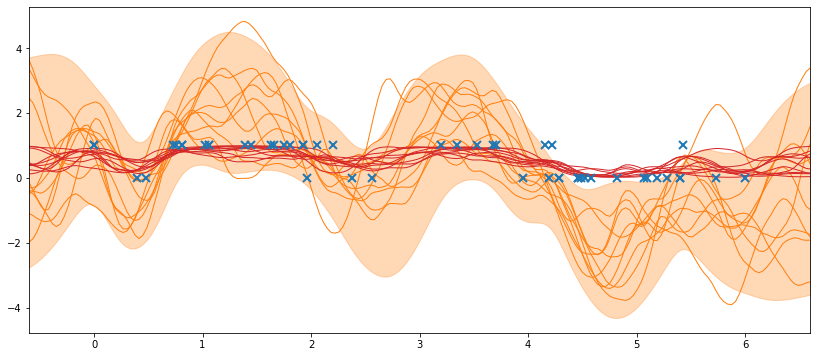

In [17]:
def plot_1d(m):
    # work out some sensible limits
    xmin, xmax = X.min(), X.max()
    xmin, xmax = xmin - 0.1 * (xmax - xmin), xmax + 0.1 * (xmax - xmin)
    Xtest = np.linspace(xmin, xmax, 200).reshape(-1, 1)
    
    # bubble fill the predictions
    mu, var = m.predict_f(Xtest)
    plt.fill_between(Xtest.flatten(),
                     (mu + 2 * np.sqrt(var)).numpy().flatten(),
                     (mu - 2 * np.sqrt(var)).numpy().flatten(),
                     alpha=0.3, color='C1')
    
    # plot samples
    samples = m.predict_f_samples(Xtest, 10).numpy().squeeze()
    plt.plot(Xtest, samples.T, 'C1', lw=1)
    
    # plot p-samples
    p = np.exp(samples) / (1. + np.exp(samples))
    plt.plot(Xtest, p.T, 'C3', lw=1)

    # plot data
    plt.plot(X, Y, 'C0x', ms=8, mew=2)
    
    plt.xlim(xmin, xmax)

plot_1d(m)

Okay, now we have a model of your dataset. Let's poke the model and see if we can understand how it works. 

### Exercise 2: poke the model

a) Print the model. Can you relate the parameters to the variables discussed in the lecture?

b) After optimizing the model, has the model managed to estimate the kernel parameters effectively? 

c) Since we know what the optimal kernel parameters are, let's see how the model works with those. Assign the known kernel parameters to the model and mark them as not for training (`gpflow.set_trainable(m.kernel.foo, False`). You will have to optimize the model again. Are these parameters better than the estimated ones? 

In [ ]:
# your answers here.

## Classification in 2D

It's straightforward to move the GP classification problem into 2D by simply changing the kernel. We'll do that here, and in addition relax the assumption that X=Z. First, let's get a simple dataset to play with from openml.

In [19]:
!pip install --quiet openml

     |████████████████████████████████| 119 kB 6.8 MB/s 
     |████████████████████████████████| 76 kB 4.9 MB/s 


In [54]:
import openml
dataset = openml.datasets.get_dataset('banana')
df, *_ = dataset.get_data()
X_banana = df.values[:1000, :2]
Y_banana = np.where(df.values[:1000, 2:]=='1', 0, 1)

In [55]:
# here's the sparse GP model:
indices = np.random.choice(X_banana.shape[0], 20)  # get some random samples to initialise SVGP

m = gpflow.models.SVGP(kernel=gpflow.kernels.Matern52(),
                       likelihood=gpflow.likelihoods.Bernoulli(),
                       inducing_variable=X_banana[indices, :])

In [56]:
# and here's a function for plotting the model
def plot_2d(m):
  
    #plot the inducing point locations:
    if hasattr(m, 'inducing_variable'):
        Z = m.inducing_variable.Z
        plt.plot(Z[:, 0], Z[:, 1], 'C3o', ms=10, label="inducing")
    
    xmin, ymin = X_banana.min(0)
    xmax, ymax = X_banana.max(0)
    xmin, xmax = xmin - 0.1 * (xmax - xmin), xmax + 0.1 * (xmax - xmin)
    ymin, ymax = ymin - 0.1 * (ymax - ymin), ymax + 0.1 * (ymax - ymin)
    
    xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
    Xtest = np.vstack([xx.flatten(), yy.flatten()]).T
    mu, var = m.predict_y(Xtest)
    
    for i, level in [[0, 0.2], [1, 0.8]]:
        plt.plot(X_banana[Y_banana.flatten()==i, 0], X_banana[Y_banana.flatten()==i, 1], 'C{}o'.format(i), ms=8, label='y={}'.format(i))
        cs = plt.contour(xx, yy, mu.numpy().reshape(*xx.shape), [level], colors='C{}'.format(i), linewidths=3)
        cs.collections[0].set_label('p(y={}) = {}'.format(i, level))
                         
    cs = plt.contour(xx, yy, mu.numpy().reshape(*xx.shape), [0.5], colors='C3', linewidths=1)
    cs.collections[0].set_label('p(y=1) = 0.5')
    
    plt.legend(loc=0)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)


### Exercise 3: understanding the model

a) Use the above function to plot the model. What's going on in the plot? 

b) Okay, optimize the model (perhaps borrow the code from the 1D model above). Plot again. Better? 

c) How do the lines in the plots correspond to our distribution on functions?

d) Investigate the effect of the *number* of the inducing input points. Try the model with 4, 12, 20, 200 rows in Z.
Plot each: what happens?

e) Investigate the effect of the *locations* of the inducing points. Does it work if you initialize them far away from the model? What does the model do if you refuse to let it adapt Z? 

bonus) Initialize the model with Z = np.zeros((10, 2)). What happens and why?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: No contour levels were found within the data range.


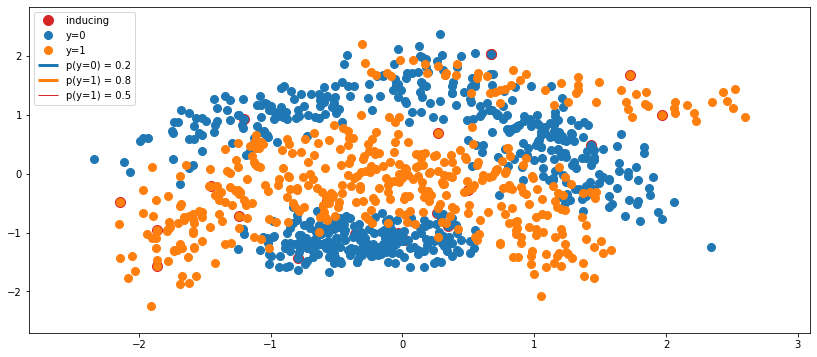

In [57]:
# Your answers here!
plot_2d(m)

In [53]:
X_banana

array([[1.14, -0.114],
       [-1.52, -1.15],
       [-1.05, 0.72],
       ...,
       [0.0598, -1.26],
       [0.51, -1.15],
       [-0.122, -0.0671]], dtype=object)